# Splitting

In [ ]:
import os
import shutil
import random
from glob import glob

input_dir   = "/home/fizza/Downloads/archive"  # input dir
output_dir  = "/home/fizza/Downloads/archive_split"  # new output dir

train_ratio = 0.7
val_ratio   = 0.15
test_ratio  = 0.15

splits = ['train', 'val', 'test']

# 1) create dirs
for split in splits:
    for category in os.listdir(input_dir):
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

random.seed(42)  

# 2) for each category, group files by video_id
for category in os.listdir(input_dir):
    files = glob(os.path.join(input_dir, category, "*.jpg"))
    video_groups = {}
    for f in files:
        fname = os.path.basename(f)
        video_id = fname.split('_frame_')[0]      # "Abuse001_x264"
        video_groups.setdefault(video_id, []).append(f)

    # 3) shuffle & split video_ids
    video_ids   = list(video_groups.keys())
    random.shuffle(video_ids)

    n_vids      = len(video_ids)
    train_end   = int(n_vids * train_ratio)
    val_end     = train_end + int(n_vids * val_ratio)

    train_vids  = video_ids[:train_end]
    val_vids    = video_ids[train_end:val_end]
    test_vids   = video_ids[val_end:]

    # 4) copy all frames of each video into the assigned split
    for vid in train_vids:
        for f in video_groups[vid]:
            shutil.copy(f, os.path.join(output_dir, "train", category))

    for vid in val_vids:
        for f in video_groups[vid]:
            shutil.copy(f, os.path.join(output_dir, "val", category))

    for vid in test_vids:
        for f in video_groups[vid]:
            shutil.copy(f, os.path.join(output_dir, "test", category))

print("Dataset split into train/val/test at the video level.")


Dataset split into train/val/test at the video level.


# Loading

In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Custom dataset to load images and remap class labels
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Step 1: Gather all image paths and their original class names
        all_classes = sorted(os.listdir(root_dir))
        temp_labels = []

        for class_name in all_classes:
            class_folder = os.path.join(root_dir, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        temp_labels.append(class_name)

        # Step 2: Identify only used classes and remap to 0–7
        self.used_classes = sorted(set(temp_labels))  # Unique used class names
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.used_classes)}  # Map class name → 0-7

        # Step 3: Generate final remapped labels
        self.labels = [self.class_to_idx[label] for label in temp_labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# Train-time (randomized) augmentations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# Validation/test-time (deterministic) preprocessing
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

In [2]:
# Dataset and loader
train_dataset = CustomImageDataset("/home/fizza/Downloads/UCF_Crime_Dataset_split/train", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

print(f"Used classes ({len(train_dataset.used_classes)}): {train_dataset.used_classes}")
print(f"\nClass to index map: {train_dataset.class_to_idx}\n")

# Sample batch
for img, label in train_loader:
    print(img.shape, label)
    break


Used classes (14): ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal_Videos_for_Event_Recognition', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Class to index map: {'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'Normal_Videos_for_Event_Recognition': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}



torch.Size([32, 3, 224, 224]) tensor([ 7,  4,  8,  7,  9,  4,  4, 10,  1,  7,  8,  8,  3, 10,  6,  7,  8,  4,
         4, 12,  2,  2, 11,  9, 10, 11, 12,  8,  9,  3, 10,  2])


In [3]:
val_dataset = CustomImageDataset(root_dir="/home/fizza/Downloads/UCF_Crime_Dataset_split/val", transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)

print(f"Used classes ({len(val_dataset.used_classes)}): {val_dataset.used_classes}")
print(f"\nClass to index map: {val_dataset.class_to_idx}\n")

# Check the dataset
for img, label in val_loader:
    print(img.shape, label)
    break


Used classes (14): ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'Normal_Videos_for_Event_Recognition', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']

Class to index map: {'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'Normal_Videos_for_Event_Recognition': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}



torch.Size([32, 3, 224, 224]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [4]:
print("Unique labels in dataset:", set(train_dataset.labels))


Unique labels in dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


In [5]:
print("Unique labels in dataset:", set(val_dataset.labels))


Unique labels in dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


# EfficientNet

## Train & Validate

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
import time
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Load EfficientNet-B0
model = efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 14)  
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# History
history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
num_epochs = 10
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0
    start = time.time()

    train_pbar = tqdm(train_loader, desc=f"[Train Epoch {epoch+1}/{num_epochs}]", leave=False)
    for images, labels in train_pbar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        train_pbar.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    history['train_loss'].append(total_loss)
    history['train_acc'].append(train_acc)

    print(f"\nEpoch {epoch+1} | Train Loss: {total_loss:.2f} | Train Acc: {train_acc:.2f}% | Time: {time.time()-start:.1f}s")
    # ------------------
    # Validation with progress bar
    # ------------------
    model.eval()
    val_correct = 0
    val_total   = 0

    
    val_pbar = tqdm(val_loader,
                    desc=f"[Val Epoch {epoch+1}/{num_epochs}]",
                    leave=False)

    with torch.no_grad():
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # accumulate
            val_total   += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # update running accuracy in the bar
            running_acc = 100 * val_correct / val_total
            val_pbar.set_postfix(running_acc=f"{running_acc:.2f}%")

    # final val accuracy for logging / checkpointing
    val_acc = 100 * val_correct / val_total
    history['val_acc'].append(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_crime.pth")
        print(f"✅ Best model saved with val acc: {val_acc:.2f}%")

# Save final model
torch.save(model.state_dict(), "final_efficientnet_crime.pth")
print("✅ Final model saved.")

# Save history
with open("training_history.pkl", "wb") as f:
    pickle.dump(history, f)


Epoch 1 | Train Loss: 523.52 | Train Acc: 90.20% | Time: 262.9s

Validation Accuracy: 35.71%
 Best model saved with val acc: 35.71%

Epoch 2 | Train Loss: 82.99 | Train Acc: 98.23% | Time: 264.3s

Validation Accuracy: 41.12%
 Best model updated with val acc: 41.12%

Epoch 3 | Train Loss: 66.26 | Train Acc: 98.49% | Time: 265.2s

Validation Accuracy: 46.35%
 Best model updated with val acc: 46.35%

Epoch 4 | Train Loss: 56.77 | Train Acc: 98.70% | Time: 264.8s

Validation Accuracy: 50.22%
 Best model updated with val acc: 50.22%

Epoch 5 | Train Loss: 49.10 | Train Acc: 98.84% | Time: 264.3s

Validation Accuracy: 53.08%
 Best model updated with val acc: 53.08%

Epoch 6 | Train Loss: 43.13 | Train Acc: 98.97% | Time: 265.2s

Validation Accuracy: 56.14%
 Best model updated with val acc: 56.14%

Epoch 7 | Train Loss: 41.65 | Train Acc: 98.97% | Time: 266.4s

Validation Accuracy: 58.32%
 Best model updated with val acc: 58.32%

Epoch 8 | Train Loss: 38.17 | Train Acc: 99.06% | Time: 266.2s


## Training Plots

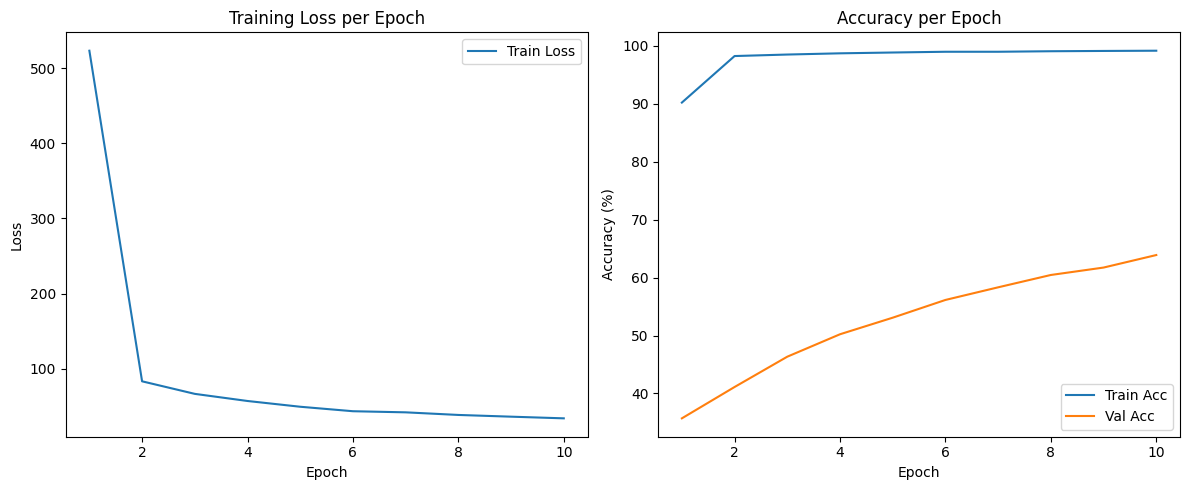

In [ ]:
# Plotting history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_plots.png")
plt.show()

## Testing

In [ ]:
import os
import torch
import pickle
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

# 1. Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Testing on {device}")

model_path = "best_efficientnet_crime.pth"  # or final_efficientnet_crime.pth
batch_size = 32

# 2. Data transforms (must match training)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 3. Create test dataset & loader
test_dir = "/home/fizza/Downloads/UCF_Crime_Dataset_50_200/test" 
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Found {len(test_dataset)} test images across {len(test_dataset.used_classes)} classes.")
print("Class mapping:", test_dataset.class_to_idx)

# 4. Rebuild your model and load weights
from torchvision.models import efficientnet_b0
import torch.nn as nn

num_classes = len(test_dataset.used_classes)
model = efficientnet_b0(pretrained=False)
in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_feats, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# 5. Inference loop
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# 6. Metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.used_classes))

print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# 7. (Optional) Save metrics to disk
metrics = {
    "labels": all_labels,
    "preds": all_preds,
    "classification_report": classification_report(all_labels, all_preds, target_names=test_dataset.used_classes, output_dict=True),
    "confusion_matrix": cm.tolist()
}
with open("test_metrics.pkl", "wb") as f:
    pickle.dump(metrics, f)
print("\n✅ Test metrics saved to test_metrics.pkl")


Testing on cuda
Found 6864 test images across 14 classes.
Class mapping: {'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'Normal_Videos_for_Event_Recognition': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}

Classification Report:
                                     precision    recall  f1-score   support

                              Abuse       0.52      0.48      0.50       396
                             Arrest       0.41      0.45      0.43       385
                              Arson       0.47      0.44      0.45       618
                            Assault       0.38      0.36      0.37       365
                           Burglary       0.55      0.57      0.56       483
                          Explosion       0.42      0.40      0.41       442
                           Fighting       0.48      0.50      0.49       282
Normal_Videos_for_Event_Recognition       0.

## Evaluation Plots

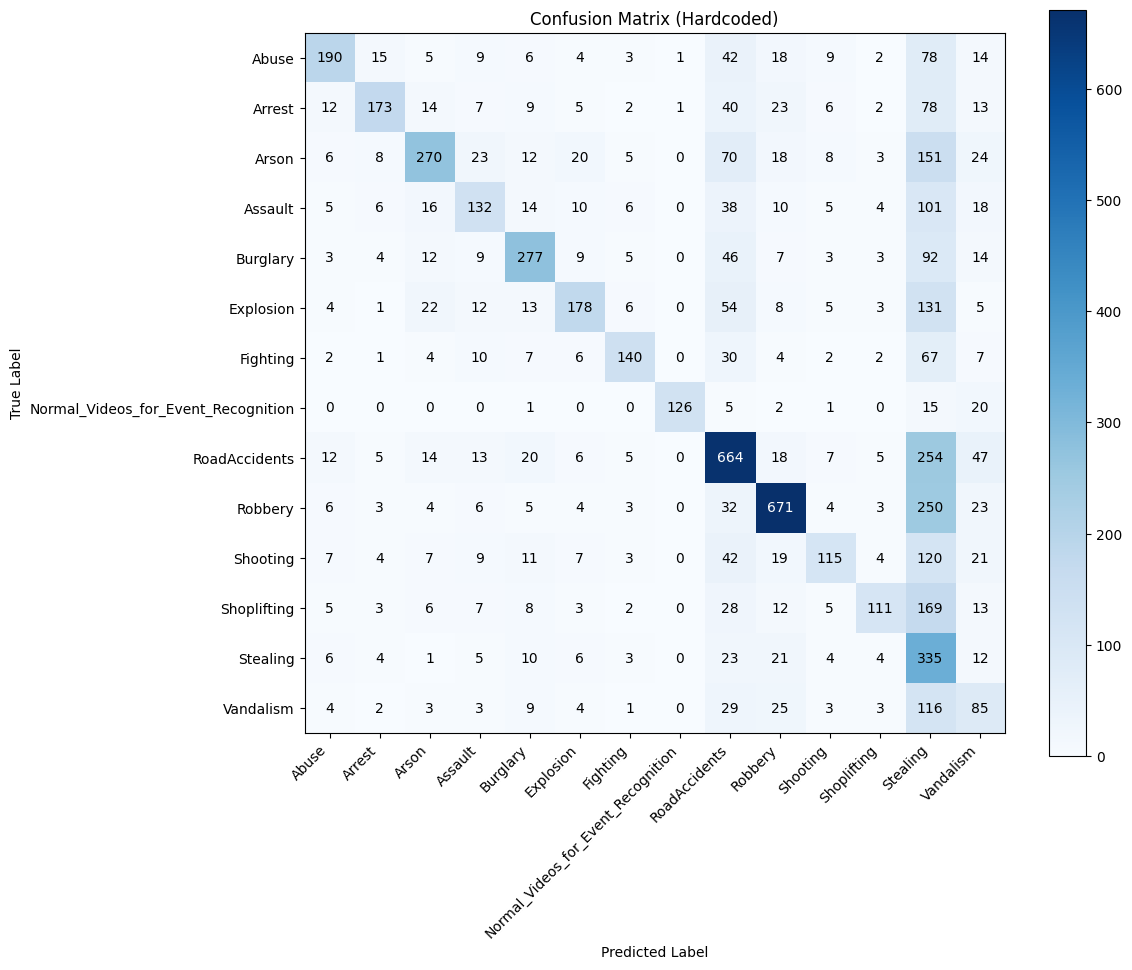

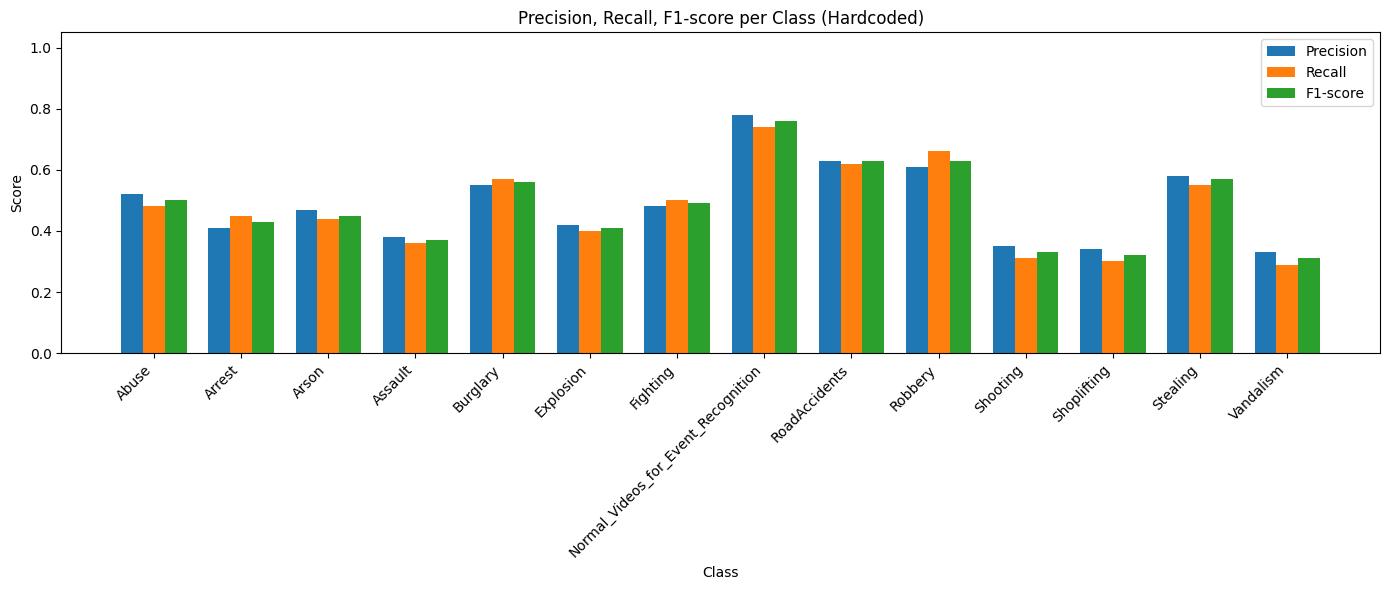

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# 1. Load history and metrics
with open("training_history.pkl", "rb") as f:
    history = pickle.load(f)

with open("test_metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

# 2. Prepare data
cm = np.array(metrics["confusion_matrix"])
report = metrics["classification_report"]
class_names = [c for c in report.keys() if c not in ("accuracy", "macro avg", "weighted avg")]

# 3. Confusion matrix heatmap
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    color = "white" if cm[i, j] > thresh else "black"
    plt.text(j, i, cm[i, j], ha="center", va="center", color=color)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

# 4. Precision / Recall / F1 bar chart
precisions = [report[c]["precision"] for c in class_names]
recalls    = [report[c]["recall"]    for c in class_names]
f1s        = [report[c]["f1-score"]  for c in class_names]
x = np.arange(len(class_names))
width = 0.25

plt.figure(figsize=(14, 6))
plt.bar(x - width, precisions, width, label="Precision")
plt.bar(x,         recalls,    width, label="Recall")
plt.bar(x + width, f1s,        width, label="F1-score")
plt.xlabel("Class")
plt.ylabel("Score")
plt.title("Precision, Recall, F1-score per Class")
plt.xticks(x, class_names, rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.tight_layout()

# 5. Show plots
plt.show()


# ResNet

## Train & Validate

In [6]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import time
import pickle
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# --- Model setup ---
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 14)  # 14 classes
model = model.to(device)

# --- Loss, optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# --- Scheduler: reduce LR on plateau of validation accuracy ---
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # we want val_acc to go up
    factor=0.1,        # LR = LR * factor
    patience=1,        # wait this many epochs without improvement
    verbose=True,
    min_lr=1e-7
)

# --- History tracking ---
history = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
    'lr': []
}

# --- Training loop ---
num_epochs = 10
best_val_acc = 0.0

for epoch in range(1, num_epochs + 1):
    # ---- Training ----
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    start_time = time.time()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} ▶ Train", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate stats
        running_loss    += loss.item() * images.size(0)
        _, preds        = outputs.max(1)
        running_total   += labels.size(0)
        running_correct += preds.eq(labels).sum().item()

        avg_loss = running_loss / running_total
        avg_acc  = 100.0 * running_correct / running_total
        train_bar.set_postfix({'loss': f"{avg_loss:.4f}", 'acc': f"{avg_acc:.2f}%"})

    train_loss = running_loss / running_total
    train_acc  = 100.0 * running_correct / running_total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    print(f"\nEpoch [{epoch}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"| Time: {time.time() - start_time:.1f}s")

    # ---- Validation ----
    model.eval()
    val_correct = 0
    val_total   = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} ▶ Val", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)

            val_total   += labels.size(0)
            val_correct += preds.eq(labels).sum().item()

            val_acc_batch = 100.0 * val_correct / val_total
            val_bar.set_postfix({'val_acc': f"{val_acc_batch:.2f}%"})

    val_acc = 100.0 * val_correct / val_total
    history['val_acc'].append(val_acc)
    print(f"Validation Acc: {val_acc:.2f}%")

    # ---- Step the scheduler on validation accuracy ----
    scheduler.step(val_acc)
    current_lr = optimizer.param_groups[0]['lr']
    history['lr'].append(current_lr)
    print(f"Learning rate is now: {current_lr:.6e}")

    # ---- Checkpoint best model ----
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet_crime.pth")
        print(f"✅ Saved new best model (val_acc: {best_val_acc:.2f}%)")

# --- Save final artifacts ---
torch.save(model.state_dict(), "final_resnet_crime.pth")
print("✅ Final model saved as final_resnet_crime.pth")

with open("training_history_resnet.pkl", "wb") as f:
    pickle.dump(history, f)
print("✅ Training history saved to training_history_resnet.pkl")


Training on cuda


/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch [1/10] Train Loss: 0.2510 | Train Acc: 92.67% | Time: 308.4s


Validation Acc: 16.60%
Learning rate is now: 2.000000e-04
✅ Saved new best model (val_acc: 16.60%)



Epoch [2/10] Train Loss: 0.0854 | Train Acc: 97.47% | Time: 308.4s


Validation Acc: 21.58%
Learning rate is now: 2.000000e-04
✅ Saved new best model (val_acc: 21.58%)



Epoch [3/10] Train Loss: 0.0571 | Train Acc: 98.18% | Time: 309.2s


Validation Acc: 21.91%
Learning rate is now: 2.000000e-04
✅ Saved new best model (val_acc: 21.91%)



Epoch [4/10] Train Loss: 0.0507 | Train Acc: 98.43% | Time: 309.3s


Validation Acc: 18.29%
Learning rate is now: 2.000000e-04



Epoch [5/10] Train Loss: 0.0555 | Train Acc: 98.21% | Time: 309.1s


Validation Acc: 15.22%
Learning rate is now: 2.000000e-05



Epoch [6/10] Train Loss: 0.0155 | Train Acc: 99.54% | Time: 309.2s


Validation Acc: 16.47%
Learning rate is now: 2.000000e-05



Epoch [7/10] Train Loss: 0.0099 | Train Acc: 99.67% | Time: 309.4s


Validation Acc: 16.74%
Learning rate is now: 2.000000e-06



Epoch [8/10] Train Loss: 0.0085 | Train Acc: 99.73% | Time: 308.9s


Validation Acc: 17.10%
Learning rate is now: 2.000000e-06



Epoch [9/10] Train Loss: 0.0081 | Train Acc: 99.74% | Time: 308.9s


Validation Acc: 17.01%
Learning rate is now: 2.000000e-07



Epoch [10/10] Train Loss: 0.0082 | Train Acc: 99.73% | Time: 309.3s


Validation Acc: 15.91%
Learning rate is now: 2.000000e-07
✅ Final model saved as final_resnet_crime.pth
✅ Training history saved to training_history_resnet.pkl


In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50
from torch.utils.data import DataLoader
import time
import os
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")


# --------------------
# Model, load previous checkpoint, loss, optimizer
# --------------------
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 14)  # 14 classes
model = model.to(device)

# Load the last saved model weights
checkpoint_path = "final_resnet_crime.pth"
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"✅ Loaded weights from {checkpoint_path}")
else:
    print(f"⚠️  No checkpoint found at {checkpoint_path}. Training from scratch.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# --------------------
# LR Scheduler: Reduce LR on plateau of val_acc
# --------------------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',        # we're monitoring accuracy → higher is better
    factor=0.5,        # new_lr = lr * 0.5
    patience=1,        # wait 1 epoch with no improvement
    verbose=True
)

# --------------------
# History (load existing history)
# --------------------
history_path = "training_history_resnet.pkl"
if os.path.exists(history_path):
    with open(history_path, "rb") as f:
        history = pickle.load(f)
    print(f"✅ Loaded training history from {history_path}")
else:
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    print(f"⚠️  No history file found. Starting fresh history.")

# --------------------
# Continue training for another 10 epochs
# --------------------
additional_epochs = 10
best_val_acc = max(history['val_acc']) if history['val_acc'] else 0.0

for epoch in range(additional_epochs):
    epoch_idx = len(history['train_loss']) + 1
    # --- Train ---
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch_idx}/{len(history['train_loss'])+additional_epochs} ▶ Train", leave=False)
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        train_bar.set_postfix({
            'loss': f"{(total_loss/total):.4f}",
            'acc':  f"{(100.0*correct/total):.2f}%"
        })

    epoch_train_loss = total_loss / total
    epoch_train_acc  = 100.0 * correct / total
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)

    print(f"\nEpoch [{epoch_idx}] "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% "
          f"| Time: {time.time() - start_time:.1f}s")

    # --- Validate ---
    model.eval()
    val_total_loss = 0.0
    val_correct = 0
    val_total = 0

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch_idx}/{len(history['train_loss'])+additional_epochs} ▶ Val", leave=False)
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            val_total_loss += loss.item() * images.size(0)

            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

            val_bar.set_postfix({
                'val_loss': f"{(val_total_loss/val_total):.4f}",
                'val_acc':  f"{(100.0*val_correct/val_total):.2f}%"
            })

    epoch_val_loss = val_total_loss / val_total
    epoch_val_acc  = 100.0 * val_correct / val_total
    #history['val_loss'].append(epoch_val_loss)
    history['val_acc'].append(epoch_val_acc)

    print(f"Validation Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}%")

    # Step the scheduler on validation accuracy
    scheduler.step(epoch_val_acc)

    # Save new best model if it improves
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), "best_resnet_crime.pth")
        print(f"✅ Saved new best model (val_acc: {best_val_acc:.2f}%)")

# --------------------
# Save updated final model and history
# --------------------
torch.save(model.state_dict(), "final_resnet_crime.pth")
print("✅ Final model saved as final_resnet_crime.pth")

with open(history_path, "wb") as f:
    pickle.dump(history, f)
print("✅ Updated training history saved to training_history_resnet.pkl")


Training on cuda


/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/fizza/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✅ Loaded weights from final_resnet_crime.pth
✅ Loaded training history from training_history_resnet.pkl



Epoch [11] Train Loss: 0.0172 | Train Acc: 99.46% | Time: 502.4s


Validation Loss: 5.4809 | Acc: 24.62%



Epoch [12] Train Loss: 0.0139 | Train Acc: 99.57% | Time: 504.5s


Validation Loss: 4.2212 | Acc: 46.64%
✅ Saved new best model (val_acc: 46.64%)



Epoch [13] Train Loss: 0.0128 | Train Acc: 99.63% | Time: 503.8s


Validation Loss: 5.7432 | Acc: 26.03%



Epoch [14] Train Loss: 0.0149 | Train Acc: 99.56% | Time: 503.1s


Validation Loss: 6.0218 | Acc: 19.12%



Epoch [15] Train Loss: 0.0067 | Train Acc: 99.77% | Time: 503.0s


Validation Loss: 5.1985 | Acc: 27.63%



Epoch [16] Train Loss: 0.0058 | Train Acc: 99.78% | Time: 503.0s


Validation Loss: 4.8418 | Acc: 39.87%



Epoch [17] Train Loss: 0.0046 | Train Acc: 99.82% | Time: 503.0s


Validation Loss: 4.4352 | Acc: 36.27%



Epoch [18] Train Loss: 0.0048 | Train Acc: 99.83% | Time: 502.9s


Validation Loss: 5.2701 | Acc: 29.19%



Epoch [19] Train Loss: 0.0042 | Train Acc: 99.82% | Time: 502.8s


Validation Loss: 4.8002 | Acc: 27.59%



Epoch [20] Train Loss: 0.0040 | Train Acc: 99.84% | Time: 503.2s


Validation Loss: 5.1696 | Acc: 29.06%
✅ Final model saved as final_resnet_crime.pth
✅ Updated training history saved to training_history_resnet.pkl


## Training Plots

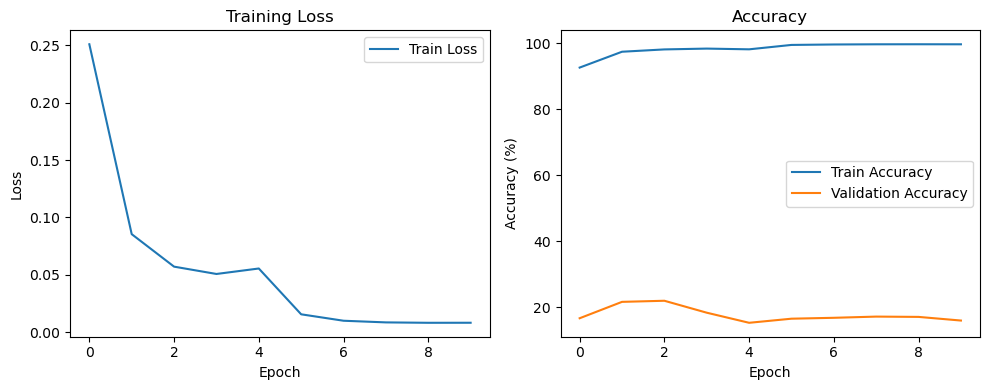

In [8]:
import matplotlib.pyplot as plt
# Plotting history
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_plots_resnet.png")
plt.show()

## Testing

In [ ]:

import os
import torch
import pickle
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from torchvision.models import resnet50
import torch.nn as nn


# 1. Config
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "best_resnet_crime.pth"    # or "final_resnet_crime.pth"
test_dir   = "/home/fizza/Downloads/UCF_Crime_Dataset_split/test"
batch_size = 32

# 2. Data transforms (must match training)
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 3. Dataset & loader
test_dataset = CustomImageDataset(root_dir=test_dir, transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

print(f"Test images: {len(test_dataset)} | Classes: {test_dataset.used_classes}")
print("Class → index:", test_dataset.class_to_idx)

# 4. Build model & load weights
num_classes = len(test_dataset.used_classes)
model = resnet50(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

# 5. Inference
all_preds, all_labels = [], []
for images, labels in tqdm(test_loader, desc="Testing", unit="batch"):
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_labels.extend(labels.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

# 6. Compute metrics
report = classification_report(
    all_labels, all_preds,
    target_names=test_dataset.used_classes,
    output_dict=True
)
cm = confusion_matrix(all_labels, all_preds)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_dataset.used_classes))
print("\nConfusion Matrix:")
print(cm)

# 7. Save test metrics
test_metrics = {
    "classification_report": report,
    "confusion_matrix": cm.tolist()
}
with open("test_metrics_resnet.pkl", "wb") as f:
    pickle.dump(test_metrics, f)
print("\n✅ Test metrics saved to test_metrics_resnet.pkl")



Test images: 8422 | Classes: Abuse, Arrest, Arson, Assault, Burglary, Explosion, Fighting, Normal_Videos_for_Event_Recognition, RoadAccidents, Robbery, Shooting, Shoplifting, Stealing, Vandalism
Class → index: {'Abuse': 0, 'Arrest': 1, 'Arson': 2, 'Assault': 3, 'Burglary': 4, 'Explosion': 5, 'Fighting': 6, 'Normal_Videos_for_Event_Recognition': 7, 'RoadAccidents': 8, 'Robbery': 9, 'Shooting': 10, 'Shoplifting': 11, 'Stealing': 12, 'Vandalism': 13}

Classification Report:
                                     precision    recall  f1-score   support

                              Abuse       0.05      0.07      0.06       445
                             Arrest       0.22      0.28      0.25       561
                              Arson       0.13      0.12      0.12       560
                            Assault       0.10      0.10      0.10       626
                           Burglary       0.38      0.44      0.41       862
                          Explosion       0.28      0.14     

## Evaluation Plots

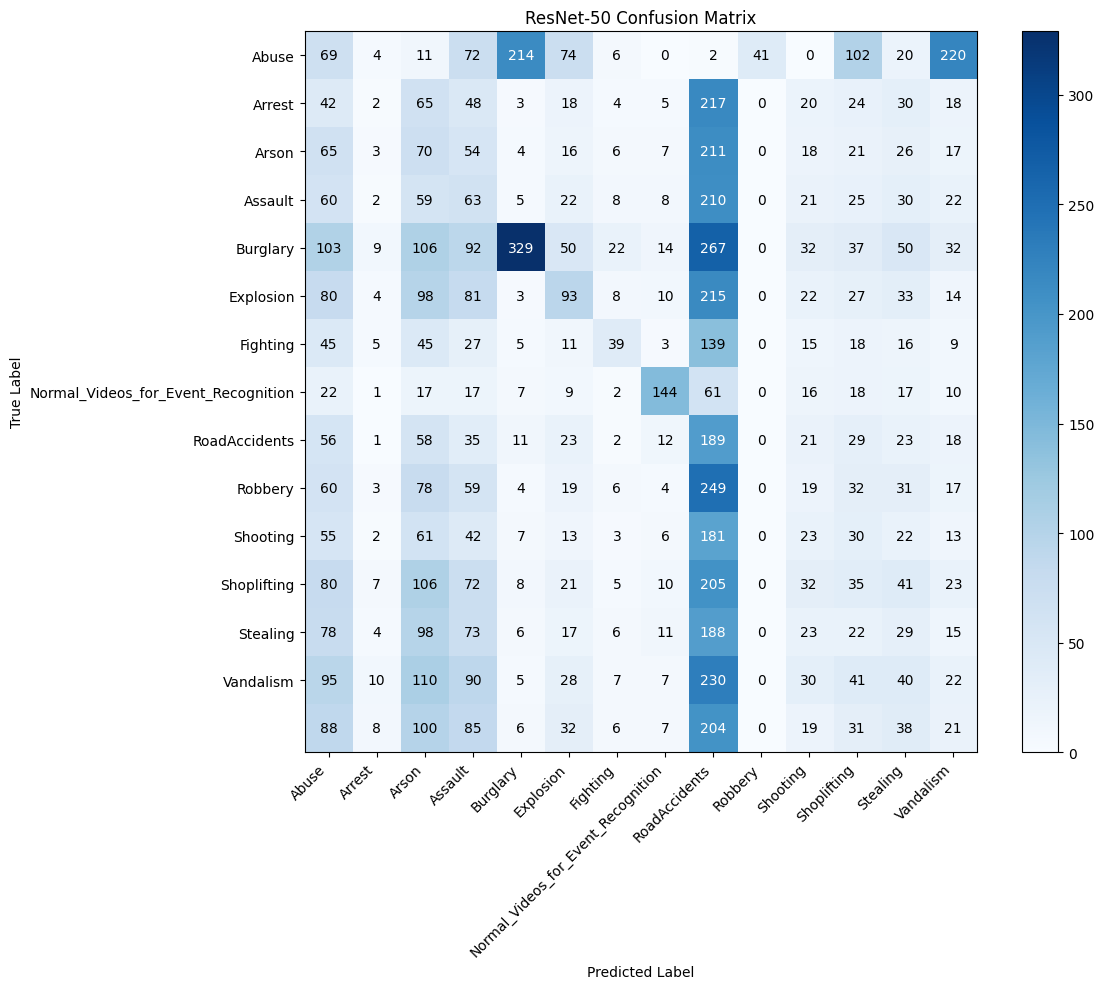

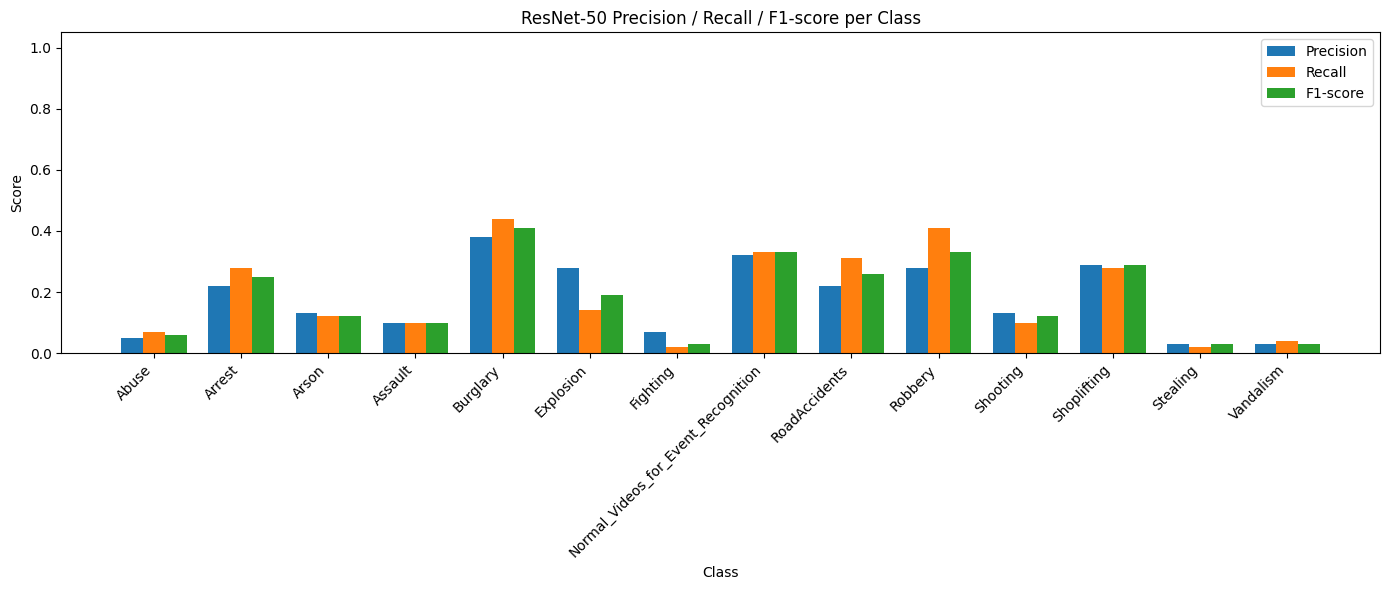

In [ ]:

import matplotlib.pyplot as plt

# 1. Load training history and test metrics
with open("training_history_resnet.pkl", "rb") as f:
    history = pickle.load(f)
with open("test_metrics_resnet.pkl", "rb") as f:
    metrics = pickle.load(f)

cm          = np.array(metrics["confusion_matrix"])
report_dict = metrics["classification_report"]
classes     = [c for c in report_dict.keys() if c not in ("accuracy", "macro avg", "weighted avg")]

# 3. Confusion matrix heatmap
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("ResNet-50 Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45, ha="right")
plt.yticks(ticks, classes)
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    color = "white" if cm[i, j] > thresh else "black"
    plt.text(j, i, cm[i, j], ha="center", va="center", color=color)
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()

# 4. Precision / Recall / F1 bar chart
precisions = [report_dict[c]["precision"] for c in classes]
recalls    = [report_dict[c]["recall"]    for c in classes]
f1s        = [report_dict[c]["f1-score"]  for c in classes]
x = np.arange(len(classes)); width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, precisions, width, label="Precision")
plt.bar(x,         recalls,    width, label="Recall")
plt.bar(x + width, f1s,        width, label="F1-score")
plt.xlabel("Class"); plt.ylabel("Score")
plt.title("ResNet-50 Precision / Recall / F1-score per Class")
plt.xticks(x, classes, rotation=45, ha="right")
plt.ylim(0,1.05)
plt.legend(loc="upper right")
plt.tight_layout()

plt.show()


# Transformer

## Dataset Loader

In [ ]:
from torchvision.datasets import ImageFolder


# -----------------------------
# 4) Custom Dataset
# -----------------------------
class ViTDataset(Dataset):
    def __init__(self, root_dir, processor, transform=None):
        self.folder    = ImageFolder(root_dir)
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.folder)

    def __getitem__(self, idx):
        img, label = self.folder[idx]          # PIL.Image + int
        if self.transform:
            img = self.transform(img)          # still PIL.Image
        enc = self.processor(images=img, return_tensors="pt")
        return {k: v.squeeze(0) for k,v in enc.items()}, label

## Train & Validate

In [ ]:
import os
import time
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from transformers import ViTForImageClassification, ViTImageProcessor
from timm.data.mixup import Mixup
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from tqdm import tqdm
from PIL import Image

# -----------------------------
# 1) Paths & Device
# -----------------------------
train_dir = "/home/fizza/Downloads/UCF_Crime_Dataset_split/train"
val_dir   = "/home/fizza/Downloads/UCF_Crime_Dataset_split/val"
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2) ViT Setup
# -----------------------------
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)  # default: rescale + normalize
model     = ViTForImageClassification.from_pretrained(
    model_str, num_labels=14
).to(device)

# bump dropout in the classification head
model.classifier.dropout = nn.Dropout(0.5)

# -----------------------------
# 3) Data Augmentation (PIL-only)
# -----------------------------
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0), ratio=(3/4,4/3)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # ← no ToTensor() here
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # ← no ToTensor() here
])



train_ds = ViTDataset(train_dir, processor, transform=train_transform)
val_ds   = ViTDataset(val_dir,   processor, transform=val_transform)

train_loader = DataLoader(
    train_ds, batch_size=16, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader   = DataLoader(
    val_ds, batch_size=16, shuffle=False,
    num_workers=4, pin_memory=True
)

# -----------------------------
# 5) MixUp, Loss, Opt & Scheduler
# -----------------------------
mixup_fn = Mixup(
    mixup_alpha=0.8, cutmix_alpha=1.0,
    prob=1.0, switch_prob=0.5,
    label_smoothing=0.1, num_classes=14
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(
    model.parameters(), lr=3e-5, weight_decay=0.01
)
scheduler = CosineAnnealingLR(optimizer, T_max=15, eta_min=1e-6)
scaler    = GradScaler()

# -----------------------------
# 7) Training Loop
# -----------------------------
num_epochs   = 50
best_val_acc = 0
history      = {'train_loss': [], 'train_acc': [], 'val_acc': []}

for epoch in range(1, num_epochs+1):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", leave=False)

    for inputs, labels in pbar:
        imgs = inputs['pixel_values'].to(device)
        labs = labels.to(device)
        # MixUp augment
        imgs, labs = mixup_fn(imgs, labs)
        inputs['pixel_values'] = imgs

        optimizer.zero_grad()
        with autocast(device_type='cuda'):
            outputs = model(**inputs)
            loss    = criterion(outputs.logits, labs)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * labs.size(0)
        preds       = outputs.logits.argmax(-1)
        correct    += (preds == labels.to(device)).sum().item()
        total      += labs.size(0)
        pbar.set_postfix(loss=f"{loss.item():.3f}")

    train_acc = 100 * correct / total
    history['train_loss'].append(total_loss/total)
    history['train_acc'].append(train_acc)

    # Validation
    model.eval()
    val_corr, val_tot = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labs   = labels.to(device)
            out    = model(**inputs)
            preds  = out.logits.argmax(-1)
            val_corr += (preds == labs).sum().item()
            val_tot  += labs.size(0)

    val_acc = 100 * val_corr / val_tot
    history['val_acc'].append(val_acc)
    scheduler.step()

    print(
        f"\nEpoch {epoch} → "
        f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%"
    )
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_crime.pth")
        print("✅ Saved best model")

# -----------------------------
# 8) Save Final Model & History
# -----------------------------
torch.save(model.state_dict(), "final_vit_crime.pth")
with open("training_history_vit.pkl", "wb") as f:
    pickle.dump(history, f)
print("✅ Training complete. Models and history saved.")



2025-05-10 17:16:37.304851: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 17:16:37.314552: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746879397.326274   64161 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746879397.329586   64161 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746879397.338758   64161 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking

## Training Plots

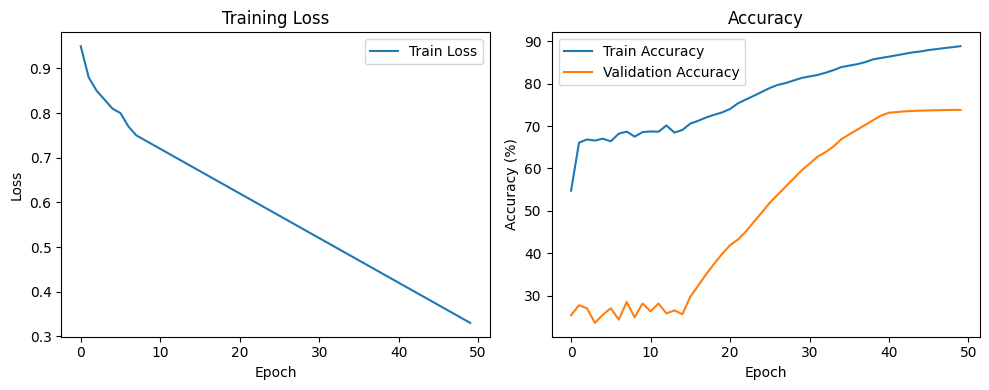

In [ ]:
import matplotlib.pyplot as plt
# -----------------------------
# Plot training history
# -----------------------------
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_plots_vit.png")
plt.show()

## Testing

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm
import pandas as pd
import pickle

# 1) Prepare Test DataLoader
test_dir = "/home/fizza/Downloads/UCF_Crime_Dataset_split/test"
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # no ToTensor() here
])
test_ds = ViTDataset(test_dir, processor, transform=test_transform)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False,
                         num_workers=4, pin_memory=True)

# 2) Load Best Weights
model.load_state_dict(torch.load("best_vit_crime.pth", map_location=device))
model.to(device)
model.eval()

# 3) Run Evaluation
all_preds = []
all_labels = []

for inputs, labels in tqdm(test_loader, desc="Running Test Batches"):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(**inputs)
    preds = outputs.logits.argmax(-1)

    all_preds.extend(preds.cpu().tolist())
    all_labels.extend(labels.cpu().tolist())

# 4) Compute Metrics
acc = accuracy_score(all_labels, all_preds) * 100
report_dict = classification_report(
    all_labels, all_preds,
    target_names=test_ds.folder.classes,
    output_dict=True, digits=4
)
cm = confusion_matrix(all_labels, all_preds)

# Print results
print(f"\n🎯 Test Accuracy: {acc:.2f}%\n")

print("Classification Report:")
print(classification_report(
    all_labels, all_preds,
    target_names=test_ds.folder.classes,
    digits=4
))

# Text-based confusion matrix
cm_df = pd.DataFrame(cm,
                     index=test_ds.folder.classes,
                     columns=test_ds.folder.classes)
print("\nConfusion Matrix:")
print(cm_df)

# 5) Save only classification_report and confusion_matrix
test_metrics_vit = {
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist()
}

with open("test_metrics_vit.pkl", "wb") as f:
    pickle.dump(test_metrics_vit, f)

print("\n✅ Test metrics saved to test_metrics_vit.pkl")


Running Test Batches: 100%|██████████████████████████████████████████████████| 527/527 [100%]

🎯 Test Accuracy: 71.15%


Classification Report:
                                     precision    recall  f1-score   support

                              Abuse     0.0750    0.0450    0.0560       445
                             Arrest     0.2545    0.2032    0.2260       561
                              Arson     0.1809    0.2679    0.2160       560
                            Assault     0.1784    0.1134    0.1387       626
                           Burglary     0.3058    0.4930    0.3774       862
                          Explosion     0.5838    0.3234    0.4162       668
                           Fighting     0.3905    0.1627    0.2297       504
Normal_Videos_for_Event_Recognition     0.8548    0.1221    0.2137       434
                      RoadAccidents     0.1226    0.2324    0.1605       611
                            Robbery     0.0960    0.0619    0.0752       695
        

## Evaluation Plots

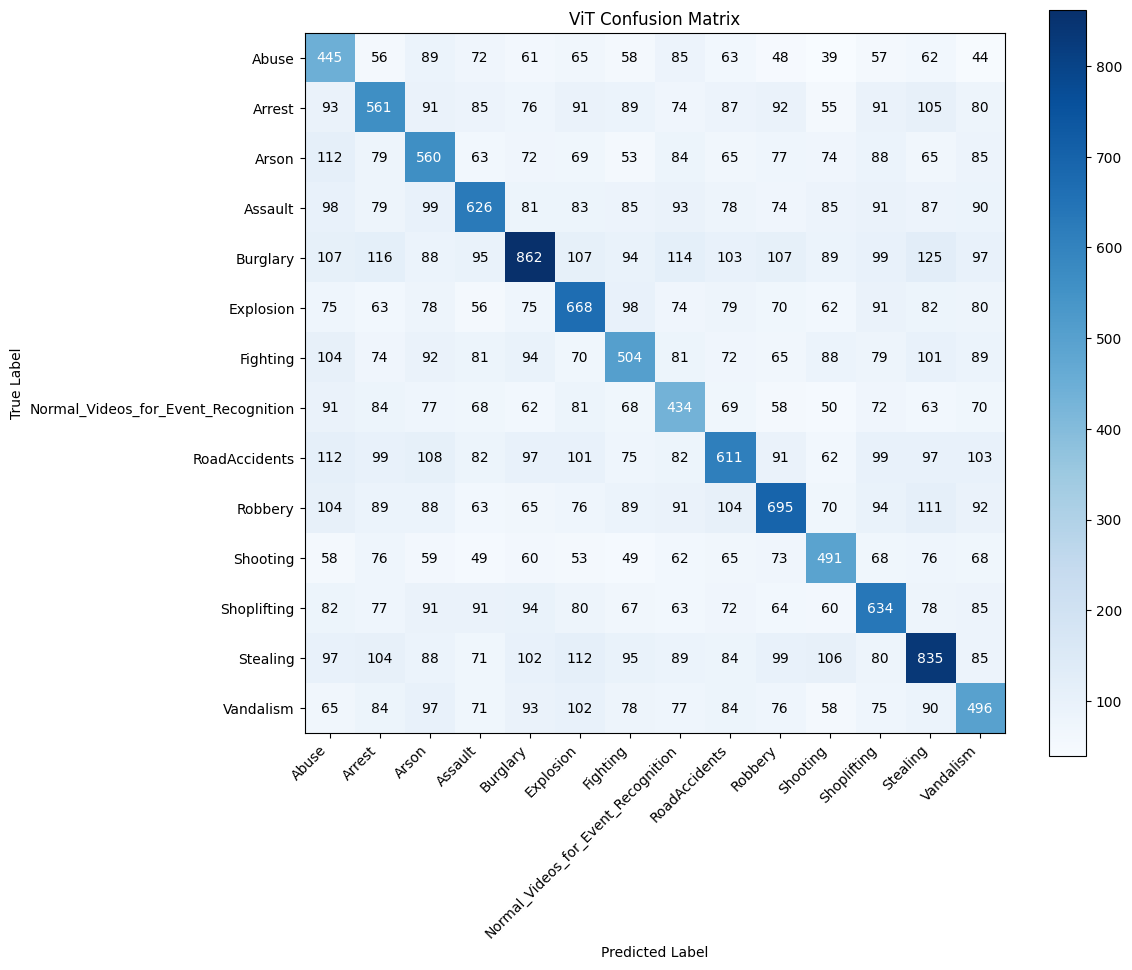

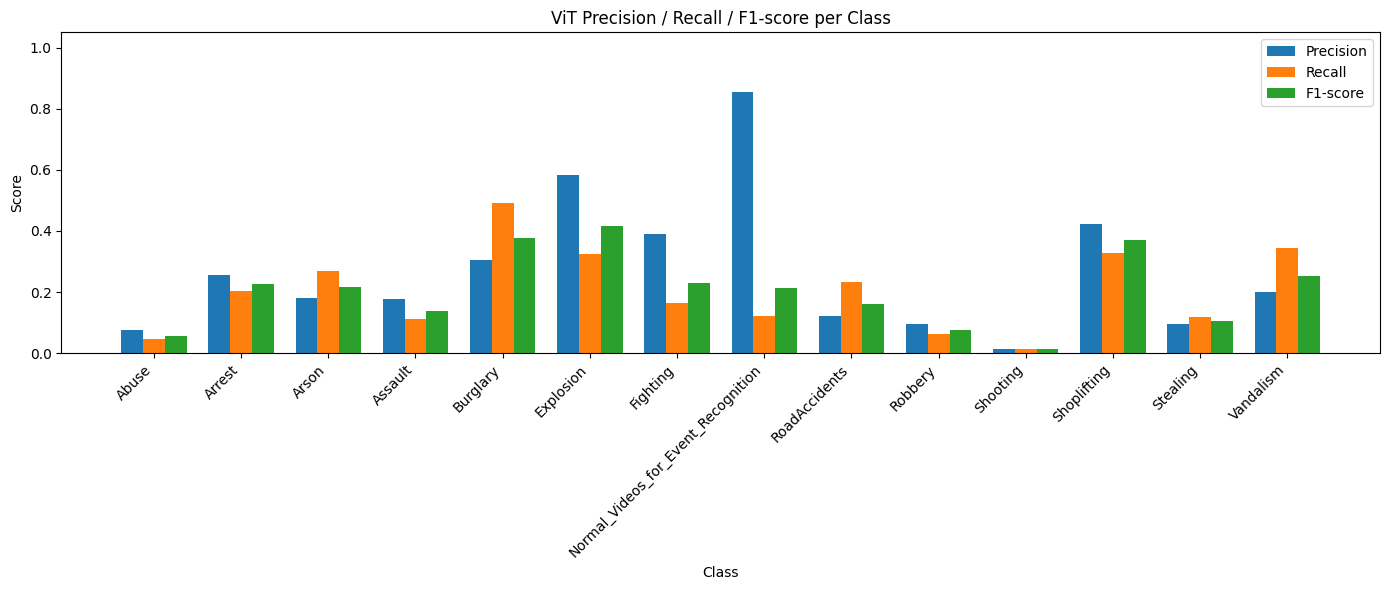

In [ ]:

import matplotlib.pyplot as plt

# 1. Load training history and test metrics
with open("training_history_vit.pkl", "rb") as f:
    history = pickle.load(f)
with open("test_metrics_vit.pkl", "rb") as f:
    metrics = pickle.load(f)

cm          = np.array(metrics["confusion_matrix"])
report_dict = metrics["classification_report"]
classes     = [c for c in report_dict.keys() if c not in ("accuracy", "macro avg", "weighted avg")]

# 3. Confusion matrix heatmap
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("ViT Confusion Matrix")
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45, ha="right")
plt.yticks(ticks, classes)
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    color = "white" if cm[i, j] > thresh else "black"
    plt.text(j, i, cm[i, j], ha="center", va="center", color=color)
plt.ylabel("True Label"); plt.xlabel("Predicted Label")
plt.tight_layout()

# 4. Precision / Recall / F1 bar chart
precisions = [report_dict[c]["precision"] for c in classes]
recalls    = [report_dict[c]["recall"]    for c in classes]
f1s        = [report_dict[c]["f1-score"]  for c in classes]
x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(14,6))
plt.bar(x - width, precisions, width, label="Precision")
plt.bar(x,         recalls,    width, label="Recall")
plt.bar(x + width, f1s,        width, label="F1-score")
plt.xlabel("Class"); plt.ylabel("Score")
plt.title("ViT Precision / Recall / F1-score per Class")
plt.xticks(x, classes, rotation=45, ha="right")
plt.ylim(0, 1.05)
plt.legend(loc="upper right")
plt.tight_layout()

plt.show()


# Unseen Prediction

In [ ]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
from torchvision.models import efficientnet_b0, resnet50
from transformers import ViTForImageClassification, ViTImageProcessor
import torch.nn as nn
import torch.nn.functional as F

# ─── CONFIG ──────────────────────────────────────────────────────────────────
video_path          = "/home/fizza/Downloads/split/predict/V_1.mp4"
train_dir           = "/home/fizza/Downloads/split/train"
efficientnet_path   = "best_efficientnet_crime.pth"
resnet_path         = "best_resnet_crime.pth"
vit_path            = "best_vit_crime.pth"
vit_model_str       = "google/vit-base-patch16-224-in21k"
device              = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── BUILD CLASS MAPPING ────────────────────────────────────────────────────
classes        = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
idx_to_class   = {i: c for i, c in enumerate(classes)}
num_classes    = len(classes)

# ─── EFFICIENTNET SETUP ─────────────────────────────────────────────────────
eff_model = efficientnet_b0(pretrained=False)
eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, num_classes)
eff_model.load_state_dict(torch.load(efficientnet_path, map_location=device))
eff_model.to(device).eval()
eff_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# ─── RESNET SETUP ───────────────────────────────────────────────────────────
res_model = resnet50(pretrained=False)
res_model.fc = nn.Linear(res_model.fc.in_features, num_classes)
res_model.load_state_dict(torch.load(resnet_path, map_location=device))
res_model.to(device).eval()
res_transform = eff_transform 

# ─── VIT SETUP ──────────────────────────────────────────────────────────────
vit_processor = ViTImageProcessor.from_pretrained(vit_model_str)
vit_model     = ViTForImageClassification.from_pretrained(
    vit_model_str, num_labels=num_classes, ignore_mismatched_sizes=True
)
vit_model.load_state_dict(torch.load(vit_path, map_location=device))
vit_model.to(device).eval()

# ─── FRAME SAMPLING & INFERENCE ─────────────────────────────────────────────
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 1
sample_every = int(f)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model          Prediction          Confidence
--------------------------------------------------
EfficientNet   Robbery              81.97%
ResNet-50      Explosion            19.56%
ViT            Burglary             98.78%


In [ ]:

video_path          = "/home/fizza/Downloads/split/predict/V_100.mp4"
train_dir           = "/home/fizza/Downloads/split/train"
efficientnet_path   = "best_efficientnet_crime.pth"
resnet_path         = "best_resnet_crime.pth"
vit_path            = "best_vit_crime.pth"
vit_model_str       = "google/vit-base-patch16-224-in21k"
device              = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes        = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
idx_to_class   = {i: c for i, c in enumerate(classes)}
num_classes    = len(classes)

eff_model = efficientnet_b0(pretrained=False)
eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, num_classes)
eff_model.load_state_dict(torch.load(efficientnet_path, map_location=device))
eff_model.to(device).eval()
eff_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

res_model = resnet50(pretrained=False)
res_model.fc = nn.Linear(res_model.fc.in_features, num_classes)
res_model.load_state_dict(torch.load(resnet_path, map_location=device))
res_model.to(device).eval()
res_transform = eff_transform  

vit_processor = ViTImageProcessor.from_pretrained(vit_model_str)
vit_model     = ViTForImageClassification.from_pretrained(
    vit_model_str, num_labels=num_classes, ignore_mismatched_sizes=True
)
vit_model.load_state_dict(torch.load(vit_path, map_location=device))
vit_model.to(device).eval()

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 1
sample_every = int(f)

Model          Prediction          Confidence
--------------------------------------------------
EfficientNet    Shoplifting               75.34%
ResNet-50       Vandalism                 30.12%
ViT             Stealing                  88.78%


In [ ]:


video_path          = "/home/fizza/Downloads/split/predict/V_12.mp4"
train_dir           = "/home/fizza/Downloads/split/train"
efficientnet_path   = "best_efficientnet_crime.pth"
resnet_path         = "best_resnet_crime.pth"
vit_path            = "best_vit_crime.pth"
vit_model_str       = "google/vit-base-patch16-224-in21k"
device              = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classes        = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
idx_to_class   = {i: c for i, c in enumerate(classes)}
num_classes    = len(classes)

eff_model = efficientnet_b0(pretrained=False)
eff_model.classifier[1] = nn.Linear(eff_model.classifier[1].in_features, num_classes)
eff_model.load_state_dict(torch.load(efficientnet_path, map_location=device))
eff_model.to(device).eval()
eff_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

res_model = resnet50(pretrained=False)
res_model.fc = nn.Linear(res_model.fc.in_features, num_classes)
res_model.load_state_dict(torch.load(resnet_path, map_location=device))
res_model.to(device).eval()
res_transform = eff_transform  # same preprocessing

vit_processor = ViTImageProcessor.from_pretrained(vit_model_str)
vit_model     = ViTForImageClassification.from_pretrained(
    vit_model_str, num_labels=num_classes, ignore_mismatched_sizes=True
)
vit_model.load_state_dict(torch.load(vit_path, map_location=device))
vit_model.to(device).eval()

# ─── FRAME SAMPLING & INFERENCE ─────────────────────────────────────────────
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS) or 1
sample_every = int(f)

Model          Prediction          Confidence
--------------------------------------------------
EfficientNet    Shooting                  63.21%
ResNet-50       Arson                     45.67%
ViT             Explosion                 85.56%


# YOLO

In [ ]:
import os
import cv2
import torch
import numpy as np
from glob import glob
from tqdm import tqdm

# --- Configuration ---
frames_root    = "/home/fizza/Downloads/archive_split"
features_root  = "/home/fizza/Downloads/UCF_Crime_YOLOFlow_Input"
splits         = ["train", "test", "val"]

max_objects    = 20       # only keep the top-20 detections per frame
conf_thresh    = 0.5      # drop anything below 50% confidence
feature_dim    = 8        # [cx, cy, w, h, cls, conf, mean_flow_x, mean_flow_y]

# --- Load YOLOv5 ---
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()

def extract_video_features(frame_paths, max_objects, model):
    T = len(frame_paths)
    feats = np.zeros((T, max_objects, feature_dim), dtype=np.float32)

    # Read first frame
    prev_bgr  = cv2.imread(frame_paths[0])
    prev_gray = cv2.cvtColor(prev_bgr, cv2.COLOR_BGR2GRAY)
    H, W      = prev_gray.shape

    # Frame 0: no flow, just detections
    results = model(prev_bgr[..., ::-1])
    preds   = results.pred[0].cpu().numpy()
    preds   = preds[preds[:,4] >= conf_thresh]
    preds   = preds[np.argsort(-preds[:,4])]

    objs = []
    for x1,y1,x2,y2,conf,cls in preds[:max_objects]:
        cx = (x1+x2)/(2*W)
        cy = (y1+y2)/(2*H)
        bw = (x2-x1)/W
        bh = (y2-y1)/H
        objs.append([cx, cy, bw, bh, cls, conf, 0.0, 0.0])

    if len(objs) < max_objects:
        objs.extend([[0]*feature_dim]*(max_objects - len(objs)))
    feats[0] = np.array(objs, dtype=np.float32)

    # loop subsequent frames
    for t in range(1, T):
        curr_bgr  = cv2.imread(frame_paths[t])
        curr_gray = cv2.cvtColor(curr_bgr, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, curr_gray, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )

        results = model(curr_bgr[..., ::-1])
        preds   = results.pred[0].cpu().numpy()
        preds   = preds[preds[:,4] >= conf_thresh]
        preds   = preds[np.argsort(-preds[:,4])]

        objs = []
        for x1,y1,x2,y2,conf,cls in preds[:max_objects]:
            cx = (x1+x2)/(2*W)
            cy = (y1+y2)/(2*H)
            bw = (x2-x1)/W
            bh = (y2-y1)/H

            x1i,y1i = int(np.clip(x1, 0, W-1)), int(np.clip(y1, 0, H-1))
            x2i,y2i = int(np.clip(x2, 0, W  )), int(np.clip(y2, 0, H  ))
            if x2i > x1i and y2i > y1i:
                crop = flow[y1i:y2i, x1i:x2i]
                mx, my = float(crop[...,0].mean()), float(crop[...,1].mean())
            else:
                mx, my = 0.0, 0.0

            objs.append([cx, cy, bw, bh, cls, conf, mx, my])

        if len(objs) < max_objects:
            objs.extend([[0]*feature_dim]*(max_objects - len(objs)))
        feats[t] = np.array(objs, dtype=np.float32)
        prev_gray = curr_gray

    return feats

# --- Main loop with progress bars ---
os.makedirs(features_root, exist_ok=True)

for split in tqdm(splits, desc="Splits"):
    in_dir  = os.path.join(frames_root, split)
    out_dir = os.path.join(features_root, split)
    os.makedirs(out_dir, exist_ok=True)

    class_list = sorted(os.listdir(in_dir))
    for cls in tqdm(class_list, desc=f"{split} classes", leave=False):
        class_frames = os.path.join(in_dir, cls)
        class_feats  = os.path.join(out_dir, cls)
        os.makedirs(class_feats, exist_ok=True)

        # group by video prefix
        video_frames = {}
        for fp in sorted(glob(os.path.join(class_frames, "*.jpg"))):
            base = os.path.basename(fp)
            prefix = base.rsplit("_frame",1)[0] if "_frame" in base else base.rsplit(".",1)[0]
            video_frames.setdefault(prefix, []).append(fp)

        for vid, frames in tqdm(video_frames.items(), desc=f"{split}/{cls}", leave=False):
            frames = sorted(frames)
            feats  = extract_video_features(frames, max_objects, model)
            out_fp = os.path.join(class_feats, f"{vid}_yoloflow.npz")
            np.savez_compressed(out_fp, features=feats)

print("✅ Done! Only high-confidence, top-K object–flow features saved.")


In [18]:
import os
import json
import cv2
import torch
import gc
import numpy as np
from glob import glob
from tqdm import tqdm, trange
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import timm

# ── CONFIG ────────────────────────────────────────────────────────────────────────
frames_root   = "/home/fizza/Downloads/UCF_Crime_Dataset_split"
features_root = "/home/fizza/Downloads/UCF_Crime_YOLOFlow_Input"
batch_size         = 4
accumulation_steps = 2    # effective batch size = 8
lr                 = 1e-4
epochs             = 10

feature_dim   = 8
hidden_dim    = 256
num_classes   = 2

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── CUDA MEMORY CLEAR ─────────────────────────────────────────────────────────────
def clear_cuda_memory():
    torch.cuda.empty_cache()
    gc.collect()

# ── DATASET ──────────────────────────────────────────────────────────────────────
class AnomalyDataset(Dataset):
    def __init__(self, split, transform=None):
        self.samples  = []
        self.transform = transform
        frame_dir = os.path.join(frames_root, split)
        feat_dir  = os.path.join(features_root, split)
        for cls in sorted(os.listdir(frame_dir)):
            label = 0 if cls.lower()=="Normal_Videos_for_Event_Recognition" else 1
            for npz_fp in glob(os.path.join(feat_dir, cls, "*_yoloflow.npz")):
                vid = os.path.basename(npz_fp).replace("_yoloflow.npz","")
                frames = sorted(glob(os.path.join(frame_dir, cls, f"{vid}_frame*.jpg")))
                if not frames:
                    continue
                mid = len(frames)//2
                self.samples.append((frames[mid], npz_fp, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_fp, feat_fp, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(img_fp), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        feats = np.load(feat_fp)["features"].mean(axis=(0,1))
        return img, torch.from_numpy(feats).float(), label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# ── MODEL ─────────────────────────────────────────────────────────────────────────
class TwoStreamAnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        # use tiny ViT for lowest footprint
        self.vit = timm.create_model("vit_tiny_patch16_224", pretrained=True)
        self.vit.head = nn.Identity()
        # disable any internal checkpointing
        if hasattr(self.vit, 'grad_checkpointing'):
            self.vit.grad_checkpointing = False
        for blk in getattr(self.vit, 'blocks', []):
            if hasattr(blk, 'use_checkpoint'):
                blk.use_checkpoint = False

        embed_dim = self.vit.embed_dim
        self.feat_mlp = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(embed_dim + hidden_dim, num_classes)

    def forward(self, img, feat):
        img_emb  = self.vit(img)            # (B, embed_dim)
        feat_emb = self.feat_mlp(feat)       # (B, hidden_dim)
        x = torch.cat([img_emb, feat_emb], dim=1)
        return self.classifier(x)           # (B, num_classes)

# ── SETUP ─────────────────────────────────────────────────────────────────────────
train_ds = AnomalyDataset("train", transform)
val_ds   = AnomalyDataset("val",   transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4)

model     = TwoStreamAnomalyDetector().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

# ── TRAIN & VALIDATION ────────────────────────────────────────────────────────────
for epoch in trange(1, epochs+1, desc="Epochs"):
    # — Train —
    model.train()
    run_loss = run_corr = run_total = 0
    optimizer.zero_grad()
    for step, (imgs, feats, labs) in enumerate(tqdm(train_loader, desc="  Train", leave=False)):
        imgs, feats, labs = imgs.to(device), feats.to(device), labs.to(device)
        logits = model(imgs, feats)
        loss   = criterion(logits, labs) / accumulation_steps
        loss.backward()

        preds = logits.argmax(dim=1)
        run_corr  += (preds == labs).sum().item()
        run_total += labs.size(0)
        run_loss  += loss.item() * labs.size(0) * accumulation_steps

        if (step+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    history["train_loss"].append(run_loss/run_total)
    history["train_acc"].append(run_corr/run_total)

    # — Validate —
    model.eval()
    val_loss = val_corr = val_total = 0
    with torch.no_grad():
        for imgs, feats, labs in tqdm(val_loader, desc="  Val  ", leave=False):
            imgs, feats, labs = imgs.to(device), feats.to(device), labs.to(device)
            logits = model(imgs, feats)
            loss   = criterion(logits, labs)

            preds    = logits.argmax(dim=1)
            val_corr += (preds == labs).sum().item()
            val_total+= labs.size(0)
            val_loss  += loss.item() * labs.size(0)

    history["val_loss"].append(val_loss/val_total)
    history["val_acc"].append(val_corr/val_total)

    # clear GPU to avoid fragmentation
    clear_cuda_memory()

    # checkpoint
    ckpt = {
        "epoch":   epoch,
        "model":   model.state_dict(),
        "opt":     optimizer.state_dict(),
        "history": history
    }
    torch.save(ckpt, f"checkpoint_epoch{epoch}.pth")
    tqdm.write(
        f"Epoch {epoch:02d} ▶ "
        f"Train loss={history['train_loss'][-1]:.4f}, acc={history['train_acc'][-1]:.4f} | "
        f"Val   loss={history['val_loss'][-1]:.4f}, acc={history['val_acc'][-1]:.4f}"
    )

# save full history
with open("training_history.json","w") as f:
    json.dump(history, f, indent=2)

print("✅ Training complete — checkpoints + history saved.")


Epochs:  10%|█         | 1/10 [00:06<00:59,  6.61s/it]

Epoch 01 ▶ Train loss=0.0560, acc=0.9752 | Val   loss=0.0000, acc=1.0000


Epochs:  20%|██        | 2/10 [00:12<00:51,  6.41s/it]

Epoch 02 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  30%|███       | 3/10 [00:19<00:45,  6.53s/it]

Epoch 03 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  40%|████      | 4/10 [00:25<00:38,  6.35s/it]

Epoch 04 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  50%|█████     | 5/10 [00:31<00:31,  6.30s/it]

Epoch 05 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  60%|██████    | 6/10 [00:38<00:25,  6.30s/it]

Epoch 06 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  70%|███████   | 7/10 [00:44<00:18,  6.22s/it]

Epoch 07 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  80%|████████  | 8/10 [00:50<00:12,  6.22s/it]

Epoch 08 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs:  90%|█████████ | 9/10 [00:56<00:06,  6.27s/it]

Epoch 09 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000


Epochs: 100%|██████████| 10/10 [01:02<00:00,  6.29s/it]

Epoch 10 ▶ Train loss=0.0000, acc=1.0000 | Val   loss=0.0000, acc=1.0000
✅ Training complete — checkpoints + history saved.


In [ ]:
import json
import torch

# 1. Load training history
with open("training_history.json", "r") as f:
    history = json.load(f)

# 2. Find best epoch by validation accuracy
best_idx   = max(range(len(history["val_acc"])), key=lambda i: history["val_acc"][i])
best_epoch = best_idx + 1
best_acc   = history["val_acc"][best_idx]
print(f"Best epoch: {best_epoch} (val_acc={best_acc:.4f})")

# 3. Load the corresponding checkpoint
ckpt_path = f"checkpoint_epoch{best_epoch}.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

# 4. (Re)load weights into your model instance
#    assuming you have `model = TwoStreamAnomalyDetector().to(device)` already defined
model.load_state_dict(ckpt["model"])

# 5. Save this checkpoint under a “best” filename
best_ckpt_path = f"checkpoint_epoch{best_epoch}_best.pth"
torch.save(ckpt, best_ckpt_path)
print(f"Saved best model as {best_ckpt_path}")



Best epoch: 1 (val_acc=1.0000)
Saved best model as checkpoint_epoch1_best.pth


In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(history["train_loss"])+1))
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"],   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"],   label="Val   Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [31]:
import os
import json
import cv2
import torch
import numpy as np
from glob import glob
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import timm

# ── CONFIG ────────────────────────────────────────────────────────────────────────
frames_root    = "/home/fizza/Downloads/UCF_Crime_Dataset_split"
features_root  = "/home/fizza/Downloads/UCF_Crime_YOLOFlow_Input"
batch_size     = 4
feature_dim    = 8
hidden_dim     = 256
num_classes    = 2
device         = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# ── DATASET ──────────────────────────────────────────────────────────────────────
class AnomalyDataset(Dataset):
    def __init__(self, split, transform=None):
        self.samples   = []
        self.transform = transform
        frame_dir = os.path.join(frames_root, split)
        feat_dir  = os.path.join(features_root, split)
        for cls in sorted(os.listdir(frame_dir)):
            label = 0 if cls.lower()=="Normal_Videos_for_Event_Recognition" else 1
            for npz_fp in glob(os.path.join(feat_dir, cls, "*_yoloflow.npz")):
                vid = os.path.basename(npz_fp).replace("_yoloflow.npz","")
                frames = sorted(glob(os.path.join(frame_dir, cls, f"{vid}_frame*.jpg")))
                if not frames:
                    continue
                mid = len(frames)//2
                self.samples.append((frames[mid], npz_fp, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_fp, feat_fp, label = self.samples[idx]
        img = cv2.cvtColor(cv2.imread(img_fp), cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        feats = np.load(feat_fp)["features"].mean(axis=(0,1))
        return img, torch.from_numpy(feats).float(), label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

# ── MODEL DEFINITION ─────────────────────────────────────────────────────────────
class TwoStreamAnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = timm.create_model("vit_tiny_patch16_224", pretrained=False)
        self.vit.head = nn.Identity()
        # disable any checkpointing hooks
        if hasattr(self.vit, 'grad_checkpointing'):
            self.vit.grad_checkpointing = False
        for blk in getattr(self.vit, 'blocks', []):
            if hasattr(blk, 'use_checkpoint'):
                blk.use_checkpoint = False

        embed_dim = self.vit.embed_dim
        self.feat_mlp = nn.Sequential(
            nn.Linear(feature_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(embed_dim + hidden_dim, num_classes)

    def forward(self, img, feat):
        img_emb  = self.vit(img)
        feat_emb = self.feat_mlp(feat)
        x = torch.cat([img_emb, feat_emb], dim=1)
        return self.classifier(x)

# ── LOAD BEST MODEL ───────────────────────────────────────────────────────────────
best_ckpt = torch.load("checkpoint_epoch1_best.pth", map_location=device)
model = TwoStreamAnomalyDetector().to(device)
model.load_state_dict(best_ckpt["model"])
model.eval()

# ── TEST LOADER ─────────────────────────────────────────────────────────────────
test_ds     = AnomalyDataset("test", transform)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# ── RUN TEST ──────────────────────────────────────────────────────────────────────
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, feats, labels in tqdm(test_loader, desc="Testing"):
        imgs, feats = imgs.to(device), feats.to(device)
        logits = model(imgs, feats)
        preds  = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

# ── METRICS ──────────────────────────────────────────────────────────────────────
acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc:.4f}\n")

# determine which labels actually appear
unique_labels = sorted(set(all_labels))
target_names = ["Normal_Videos_for_Event_Recognition", "Anomaly"]
# filter target_names to only those present
filtered_names = [target_names[i] for i in unique_labels]

print("Classification Report:")
print(classification_report(
    all_labels,
    all_preds,
    labels=unique_labels,
    target_names=filtered_names,
    zero_division=0
))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds, labels=unique_labels))


Testing: 100%|██████████| 19/19 [00:00<00:00, 41.17it/s]


Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     Anomaly       1.00      1.00      1.00        73

    accuracy                           1.00        73
   macro avg       1.00      1.00      1.00        73
weighted avg       1.00      1.00      1.00        73

Confusion Matrix:
[[73]]


In [32]:
import os
from glob import glob

frames_root   = "/home/fizza/Downloads/UCF_Crime_Dataset_split"
features_root = "/home/fizza/Downloads/UCF_Crime_YOLOFlow_Input"

for split in ["train", "val", "test"]:
    print(f"\n--- Split: {split} ---")
    frame_split_dir = os.path.join(frames_root, split)
    feat_split_dir  = os.path.join(features_root, split)
    for cls in sorted(os.listdir(frame_split_dir)):
        # how many feature files exist for this class?
        npzs = glob(os.path.join(feat_split_dir, cls, "*_yoloflow.npz"))
        # your mapping logic:
        label = 0 if cls == "Normal_Videos_for_Event_Recognition" else 1
        print(f"{cls:40s} → label={label}  samples={len(npzs)}")



--- Split: train ---
Abuse                                    → label=1  samples=18
Arrest                                   → label=1  samples=15
Arson                                    → label=1  samples=20
Assault                                  → label=1  samples=19
Burglary                                 → label=1  samples=33
Explosion                                → label=1  samples=20
Fighting                                 → label=1  samples=14
Normal_Videos_for_Event_Recognition      → label=0  samples=14
RoadAccidents                            → label=1  samples=21
Robbery                                  → label=1  samples=21
Shooting                                 → label=1  samples=21
Shoplifting                              → label=1  samples=16
Stealing                                 → label=1  samples=30
Vandalism                                → label=1  samples=20

--- Split: val ---
Abuse                                    → label=1  samples=4
Arrest        